<a href="https://colab.research.google.com/github/tackulus/204426_PROJECT/blob/main/Sprite_download.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pokebase

In [ ]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pokebase as pb
from tqdm import tqdm

In [48]:
sprite_rgba = []
for i in tqdm(range(1,802)):
    source = pb.SpriteResource('pokemon', i, official_artwork=True)
    binary = source.img_data
    img = plt.imread(io.BytesIO(binary))
    img = np.asarray(img)
    sprite_rgba.append(img)

sprite_rgba = np.asarray(sprite_rgba)
sprite_rgba.shape # pokedex n == index n-1

100%|██████████| 801/801 [00:00<00:00, 1686.91it/s]


(801, 96, 96, 4)

In [49]:
from skimage.color import rgba2rgb

sprite_rgb = [rgba2rgb(img_rgba) for img_rgba in tqdm(sprite_rgba)]
sprite_rgb = np.asarray(sprite_rgb)
sprite_rgb.shape # pokedex n == index n-1

100%|██████████| 801/801 [00:00<00:00, 4095.43it/s]


(801, 96, 96, 3)

# 4.1) Feature Extraction by Histogram of Orientation Gradient (HOG)
> https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/

In [88]:
from skimage.feature import hog

def feature_extraction_hog(img):
    fd, hog_image = hog(img, orientations=9, pixels_per_cell=(6,6), 
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
    return fd, hog_image

sprite_hog = []
sprite_hog_img = []
for img_rgb in tqdm(sprite_rgb):
    fd, hog_image = feature_extraction_hog(img_rgb)
    sprite_hog.append(fd)
    sprite_hog_img.append(hog_image)

sprite_hog = np.asarray(sprite_hog)
sprite_hog_img = np.asarray(sprite_hog_img)
sprite_hog.shape, sprite_hog_img.shape # pokedex n == index n-1

100%|██████████| 801/801 [00:41<00:00, 19.15it/s]


((801, 8100), (801, 96, 96))

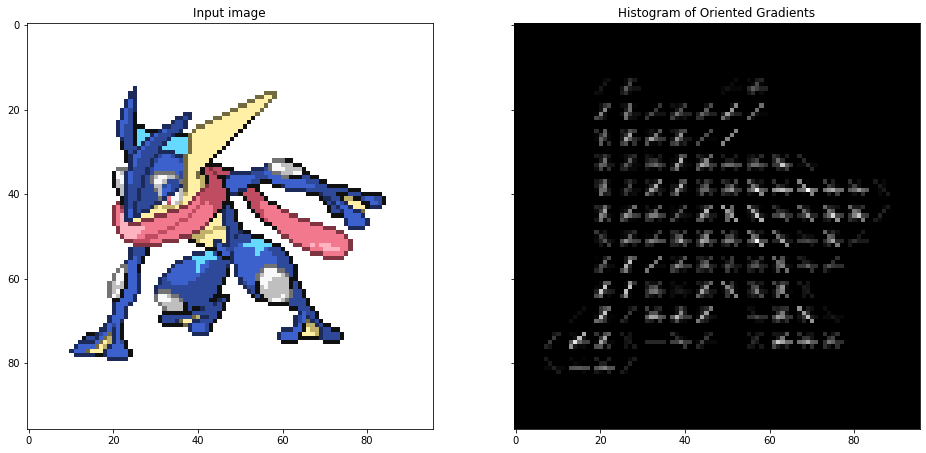

In [149]:
from skimage import exposure

pokedex = 658
img, hog_img = sprite_rgb[pokedex-1], sprite_hog_img[pokedex-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 

ax1.imshow(img, cmap=plt.cm.gray) 
ax1.set_title('Input image') 

# Rescale histogram for better display 
hog_image_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 10)) 

ax2.imshow(hog_img, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients')

plt.show()

In [ ]:
import pandas as pd

df = pd.DataFrame(sprite_hog)
df.to_csv('sprite_hog.csv', index=False)

# 4.2) Feature Extraction by Color Histogram
> https://www.etutorialspoint.com/index.php/310-python-opencv-histograms-of-color-image

In [147]:
import cv2 as cv

def color_histogram(img_rgba, bins=32):
    img = (img_rgba * 255).astype('uint8')
    mask = img[...,3]
    hist1 = cv.calcHist([img],[0],mask,[bins],[0,256])
    hist2 = cv.calcHist([img],[1],mask,[bins],[0,256])
    hist3 = cv.calcHist([img],[2],mask,[bins],[0,256])

    return np.array([hist1, hist2, hist3] / hist1.sum())[...,0]
    
sprite_hist = [color_histogram(img_rgba) for img_rgba in tqdm(sprite_rgba)]
sprite_hist = np.asarray(sprite_hist)

n, ch, bins = sprite_hist.shape 
sprite_hist_flatten = sprite_hist.reshape((n, ch * bins))
sprite_hist.shape, sprite_hist_flatten.shape # pokedex n == index n-1

100%|██████████| 801/801 [00:00<00:00, 8491.16it/s]


((801, 3, 32), (801, 96))

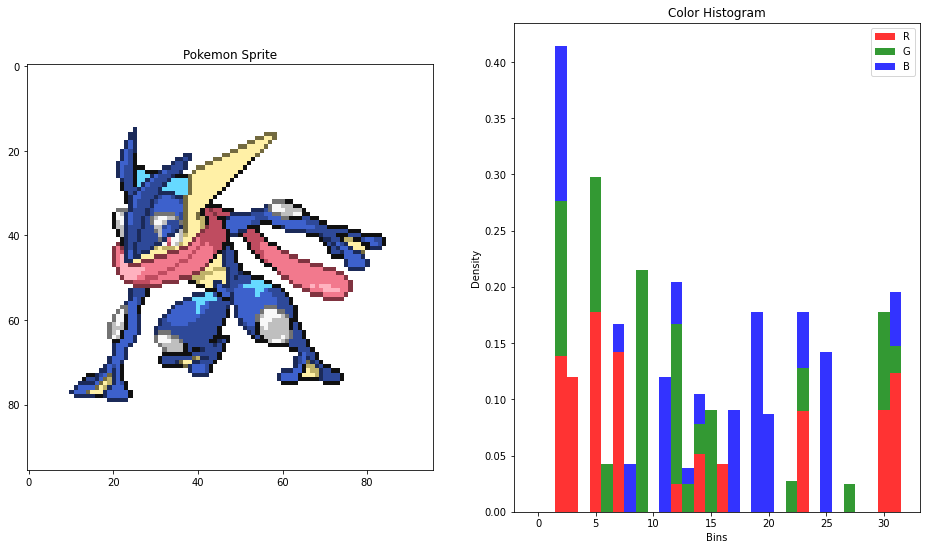

In [145]:
plt.figure(figsize=(16,9))

R, G, B = sprite_hist[657]

plt.subplot(121)
plt.imshow(sprite_rgb[657])
plt.title('Pokemon Sprite')


bins = R.shape[0]
plt.subplot(122)
plt.bar(range(bins), R, color='r',
        width=1, alpha=0.8)
plt.bar(range(bins), G, color='g',
        bottom=R,
        width=1, alpha=0.8)
plt.bar(range(bins), B, color='b',
        bottom=R+G,
        width=1, alpha=0.8)
plt.title('Color Histogram')
plt.legend(['R', 'G', 'B'])
plt.xlabel('Bins')
plt.ylabel('Density')
plt.show()

In [148]:
import pandas as pd

df = pd.DataFrame(sprite_hist_flatten)
df.to_csv('sprite_hist_flatten.csv', index=False)

# 5) Data Quality

In [167]:
pokemon.isna().sum()

pokedex_number       0
name                 0
japanese_name        0
hp                   0
attack               0
defense              0
sp_attack            0
sp_defense           0
speed                0
weight_kg            0
height_m             0
percentage_male      0
experience_growth    0
capture_rate         0
classfication        0
base_egg_steps       0
base_happiness       0
base_total           0
abilities            0
against_bug          0
against_dark         0
against_dragon       0
against_electric     0
against_fairy        0
against_fight        0
against_fire         0
against_flying       0
against_ghost        0
against_grass        0
against_ground       0
against_ice          0
against_normal       0
against_poison       0
against_psychic      0
against_rock         0
against_steel        0
against_water        0
generation           0
is_legendary         0
bug                  0
dark                 0
dragon               0
electric             0
fairy      

In [168]:
# Check Completeness of Pokemon data
n, n_feature = pokemon.shape
len_data = n * n_feature
ratio = 1 - (pokemon.isna().sum().sum() / len_data)
ratio

1.0

In [161]:
# Check Completeness of Pokemon Sprite RGBA color image
n, x, y, ch = sprite_rgba.shape
len_data = n * x * y * ch
ratio = 1 - (np.isnan(sprite_rgba).sum() / len_data)
ratio

1.0

In [185]:
# Chech non-negative validity of Pokemon numerical data
for col in pokemon.columns:
    if pokemon.dtypes[col] != 'object':
        test = pokemon[col] < 0
        ratio = 1-(test.sum() / len(pokemon[col]))
        print(f'{ratio:.2f} | {col}')

1.00 | pokedex_number
1.00 | hp
1.00 | attack
1.00 | defense
1.00 | sp_attack
1.00 | sp_defense
1.00 | speed
1.00 | weight_kg
1.00 | height_m
1.00 | percentage_male
1.00 | experience_growth
1.00 | base_egg_steps
1.00 | base_happiness
1.00 | base_total
1.00 | against_bug
1.00 | against_dark
1.00 | against_dragon
1.00 | against_electric
1.00 | against_fairy
1.00 | against_fight
1.00 | against_fire
1.00 | against_flying
1.00 | against_ghost
1.00 | against_grass
1.00 | against_ground
1.00 | against_ice
1.00 | against_normal
1.00 | against_poison
1.00 | against_psychic
1.00 | against_rock
1.00 | against_steel
1.00 | against_water
1.00 | generation
1.00 | is_legendary
1.00 | bug
1.00 | dark
1.00 | dragon
1.00 | electric
1.00 | fairy
1.00 | fighting
1.00 | fire
1.00 | flying
1.00 | ghost
1.00 | grass
1.00 | ground
1.00 | ice
1.00 | normal
1.00 | poison
1.00 | psychic
1.00 | rock
1.00 | steel
1.00 | water


In [199]:
pokemon.columns

Index(['pokedex_number', 'name', 'japanese_name', 'hp', 'attack', 'defense',
       'sp_attack', 'sp_defense', 'speed', 'weight_kg', 'height_m',
       'percentage_male', 'experience_growth', 'capture_rate', 'classfication',
       'base_egg_steps', 'base_happiness', 'base_total', 'abilities',
       'against_bug', 'against_dark', 'against_dragon', 'against_electric',
       'against_fairy', 'against_fight', 'against_fire', 'against_flying',
       'against_ghost', 'against_grass', 'against_ground', 'against_ice',
       'against_normal', 'against_poison', 'against_psychic', 'against_rock',
       'against_steel', 'against_water', 'generation', 'is_legendary', 'bug',
       'dark', 'dragon', 'electric', 'fairy', 'fighting', 'fire', 'flying',
       'ghost', 'grass', 'ground', 'ice', 'normal', 'poison', 'psychic',
       'rock', 'steel', 'water'],
      dtype='object')

# 6. Visualization

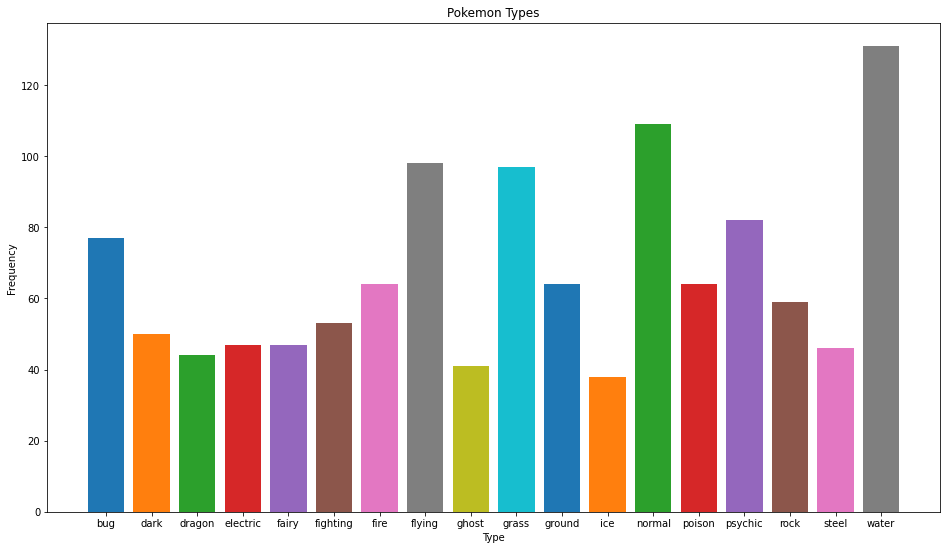

In [198]:
# Pokemon Types Visualization
cols = pokemon.columns[-18:]

plt.figure(figsize=(16,9))
for col in cols:
    plt.bar(col, pokemon[col].sum())
plt.title('Pokemon Types')
plt.xlabel('Type')
plt.ylabel('Frequency')
plt.show()

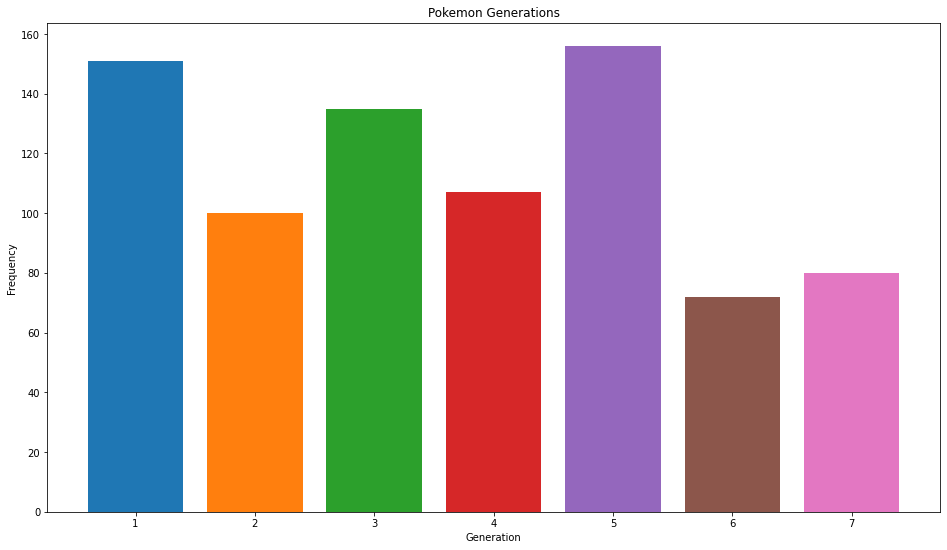

In [209]:
# Pokemon Generations Visualization
cols = pokemon.columns[-18:]

count = pokemon.groupby('generation').count().iloc[:,0]

plt.figure(figsize=(16,9))
for gen, val in count.items():
    plt.bar(gen, val)
plt.title('Pokemon Generations')
plt.xlabel('Generation')
plt.ylabel('Frequency')
plt.show()

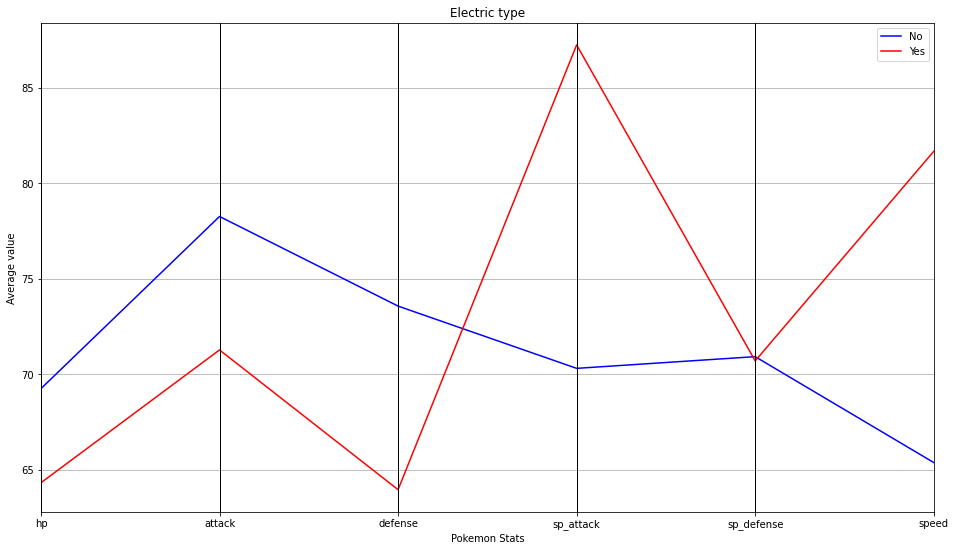

In [221]:
from itertools import cycle, islice

df = pokemon.groupby('electric').mean()
df['YN'] = ['No', 'Yes']

plt.figure(figsize=(16,9))
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
pd.plotting.parallel_coordinates(df, 'YN', pokemon.columns[3:9], color=my_colors)
plt.xlabel('Pokemon Stats')
plt.ylabel('Average value')
plt.title('Electric type')
plt.show()

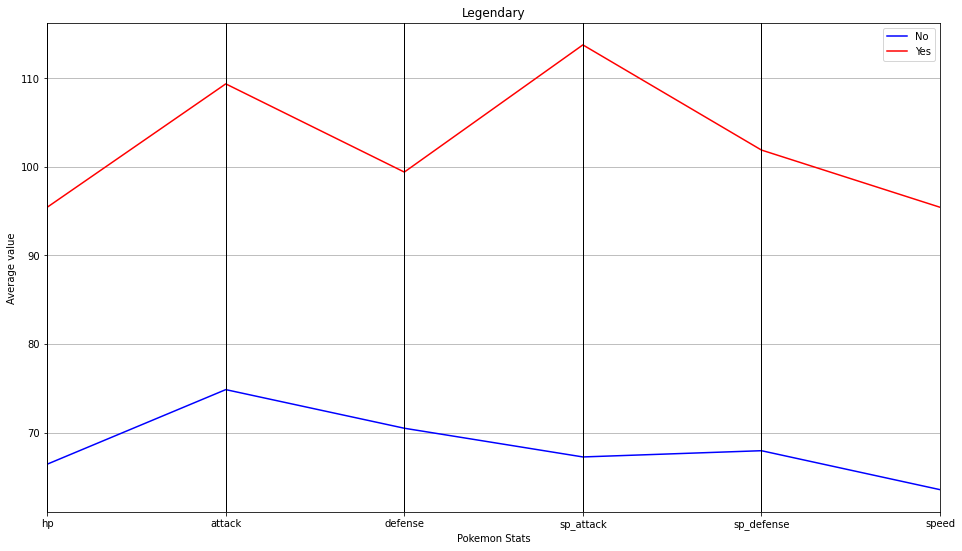

In [233]:
df = pokemon.groupby('is_legendary').mean()
df['YN'] = ['No', 'Yes']

plt.figure(figsize=(16,9))
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
pd.plotting.parallel_coordinates(df, 'YN', pokemon.columns[3:9], color=my_colors)
plt.xlabel('Pokemon Stats')
plt.ylabel('Average value')
plt.title('Legendary')
plt.show()

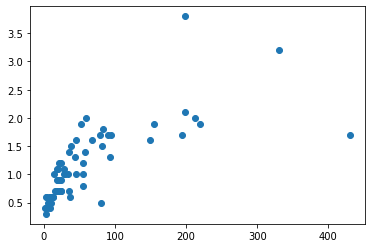

In [231]:
cols = pokemon.columns[-18:]

for colx in cols:
    col = 'fire'
    df = pokemon[pokemon[col]==1]
    plt.scatter(df.weight_kg, df.height_m)
    break